In [145]:
import pandas as pd
import sklearn
from sklearn.svm import SVR
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
import torch, numpy as np, torch.nn as nn
from torch.autograd import variable
import torchvision.transforms as transforms, torchvision.datasets as dsets

Index(['Date', 'Daily Confirmed', 'Total Confirmed', 'Daily Recovered',
       'Total Recovered', 'Daily Deceased', 'Total Deceased'],
      dtype='object')
(255, 3)


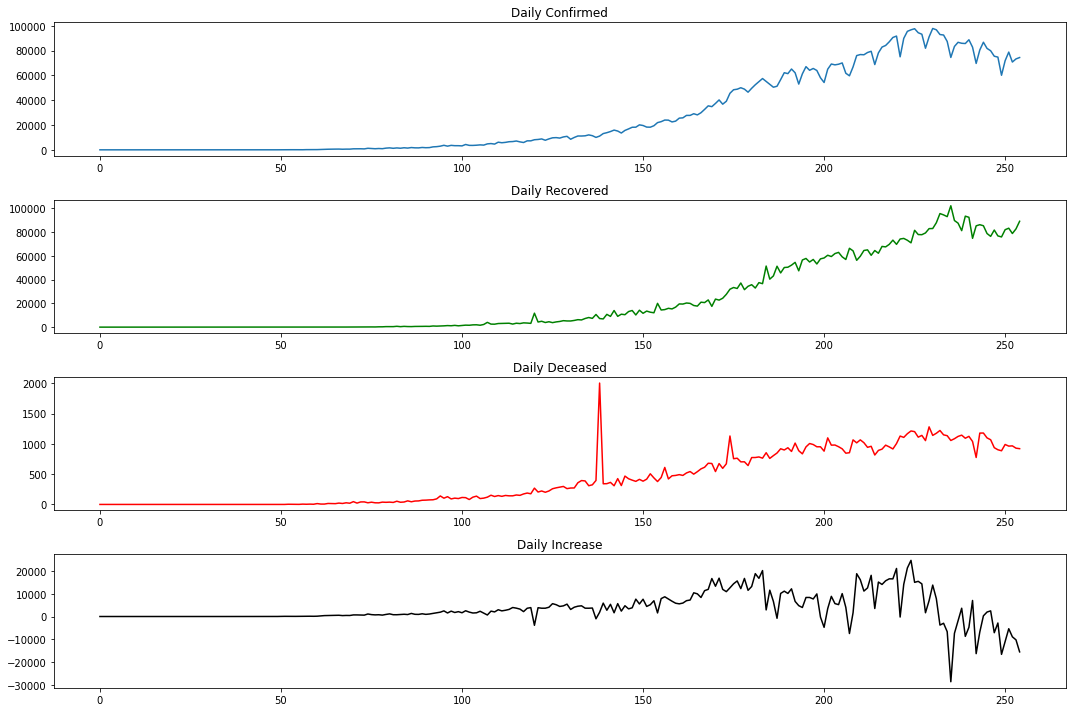

In [146]:
df = pd.read_csv("case_time_series.csv")
#df['Date'] = pd.to_datetime(df['Date'])
print(df.columns)

increase = df['Daily Confirmed'] - df['Daily Recovered'] - df['Daily Deceased']
fig,(a1, a2, a3, a4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
a1.plot(df['Daily Confirmed'])
a1.set_title('Daily Confirmed')
a2.plot(df['Daily Recovered'], color = 'green')
a2.set_title('Daily Recovered')
a3.plot(df['Daily Deceased'], color= 'red')
a3.set_title('Daily Deceased')
a4.plot(increase, color= 'black')
a4.set_title('Daily Increase')  # from this grapg we can infer that lately the number of increase in daily positive patients is going down (i.e no of people testing positive is less when compared to number of people getting recovered or deaths reported)
fig.tight_layout()

df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 0].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 0].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()


In [32]:
input_dim = 3
hidden_dim = 15
layer_dim = 3
batch_size = 1
train_window = 5
output_dim = 1
learning_rate = 0.001

In [33]:
#----------------------------> Creating Dataloader <----------------------------------------------------
def create_inout_sequences(input_data, input_label, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_label[i+tw:i+tw+1]
        train_seq = torch.reshape(train_seq, (batch_size, tw, input_dim))
        train_label = torch.reshape(train_label, (batch_size, 1, 1))
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# -----------------------------------------> LOADING DATA <----------------------------------------------
train_data_tensor = torch.FloatTensor(data_train)
label_data_tensor = torch.FloatTensor(label_train)
train_inout_seq = create_inout_sequences(train_data_tensor, label_data_tensor, train_window)

test_data_tensor = torch.FloatTensor(data_test)
label_test_data_tensor = torch.FloatTensor(label_test)
test_inout_seq = create_inout_sequences(test_data_tensor, label_test_data_tensor, train_window)

In [34]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        #Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        #Number Of Hidden Layers
        self.layer_dim = layer_dim
        
        #Building Your RNN
        #batch_first = True causes input/output tensors to be of shape
        #(batch_dim, seq_dim, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity ="tanh")
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h):
        
        #Initialize Hidden States With Zeros
        #layer_dim, batch_size, hidden_dim
        h1 = variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One Time Step
        out, h = self.rnn(x, h1)
        
        #Index hidden state of last time step
        #Out.size() 
        #Out[:, -1, :]  just want last time step hidden states
        out = self.fc(out[:, -1, :])
        
        #Out size
        return out, h


In [37]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

print(len(list(model.parameters())))
print(list(model.parameters())[0].size())
print(list(model.parameters())[1].size())
print(list(model.parameters())[2].size())
print(list(model.parameters())[3].size())
print(list(model.parameters())[4].size())
print(list(model.parameters())[5].size())

num_epochs = 200
h0 = torch.zeros(layer_dim, batch_size, hidden_dim)
h0_t = torch.zeros(layer_dim, batch_size, hidden_dim)


for epoch in range(num_epochs):
  for seq, labels in train_inout_seq:
      optimizer.zero_grad()
      y_pred, h0 = model(seq, h0)
      single_loss = criterion(y_pred, labels)
      single_loss.backward()
      h0 = h0.detach()
      optimizer.step()  
  if epoch%24 == 0:
        model.eval()
        for seq_t, labels_t in test_inout_seq:
          y_pred_t, _ = model(seq_t, h0_t)
          test_loss = criterion(y_pred_t, labels_t)
        print(f'Epoch: {epoch+1:2}---> Training:- Loss: {single_loss.item():10.8f} ----- Testing:- Loss: {test_loss.item():10.8f}')
        model.train()

14
torch.Size([15, 3])
torch.Size([15, 15])
torch.Size([15])
torch.Size([15])
torch.Size([15, 15])
torch.Size([15, 15])


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:214: UserWarning:

torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:215: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning:

Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch:  1---> Training:- Loss: 0.69347042 ----- Testing:- Loss: 0.39295378
Epoch: 25---> Training:- Loss: 0.00003102 ----- Testing:- Loss: 0.00364580
Epoch: 49---> Training:- Loss: 0.00002057 ----- Testing:- Loss: 0.00296264
Epoch: 73---> Training:- Loss: 0.00007272 ----- Testing:- Loss: 0.00235746
Epoch: 97---> Training:- Loss: 0.00010659 ----- Testing:- Loss: 0.00190316
Epoch: 121---> Training:- Loss: 0.00012597 ----- Testing:- Loss: 0.00156931
Epoch: 145---> Training:- Loss: 0.00013756 ----- Testing:- Loss: 0.00132219
Epoch: 169---> Training:- Loss: 0.00014540 ----- Testing:- Loss: 0.00113674
Epoch: 193---> Training:- Loss: 0.00015163 ----- Testing:- Loss: 0.00099544


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:214: UserWarning:

torch.autograd.variable(...) is deprecated, use torch.tensor(...) instead

/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:215: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[84481, 84622, 83381, 82018, 79696, 74113, 73554, 76874, 76291, 75934]


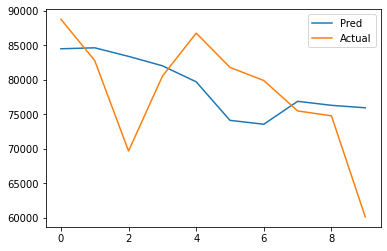

In [42]:
h0_pred = torch.zeros(layer_dim, batch_size, hidden_dim)
fut_pred = 10
model.eval()
test_inp = []
for i in range(fut_pred):
  to_pred = torch.FloatTensor(data_test[i:i+train_window])
  to_pred = torch.reshape(to_pred, (batch_size, train_window, input_dim))
  seq = to_pred
  with torch.no_grad():
      test_inp.append([model(seq, h0_pred)[0], 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
#print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

a = df['Daily Confirmed'].loc[240:249]
stats_df = []
for i in a:
  stats_df.append(i)
print(stats)
plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

In [53]:
df_ = pd.read_csv("case_time_series.csv")
Date = df_["Date"]
dt = Date[240:]
print(len(dt), len(stats))

15 10


### **VAR** Model

(255, 3)
   Daily Confirmed Daily Recovered Daily Deceased
0          77675.7         84723.1        991.792
1          80149.8         81994.8        1042.39
2          82084.2         80345.8        1079.71
3            83649         79437.7        1108.14
4            84962         79038.1        1130.59
5          86103.9         78987.9        1148.98
6          87130.2         79178.1        1164.63
7          88078.9         79534.1        1178.42
8          88976.1         80004.8        1190.96
9          89839.5         80555.4        1202.67
10         90681.4         81162.1        1213.83
11         91510.1         81808.6        1224.64
12         92331.3         82483.6        1235.21
13           93149         83179.7        1245.66
14         93965.9         83891.5        1256.03
rmse value for Daily Deceased is :  227.13997360339587


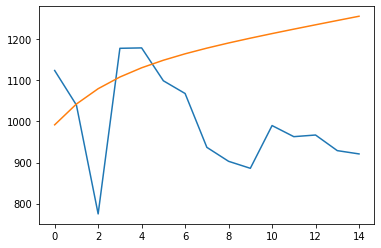

rmse value for Daily Recovered is :  4531.093346072239


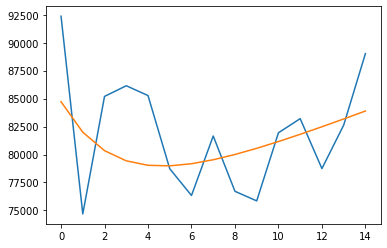

rmse value for Daily Confirmed is :  14980.45390306619


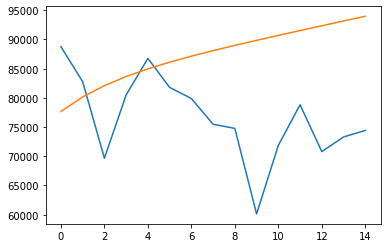

In [154]:
from statsmodels.tsa.api import VAR

df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = (df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 2].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 2].to_numpy()


cols = df.columns

Var = VAR(endog = data_train)
Var_fit = Var.fit()
#print(Var.score(data_test,label_test))
prediction = Var_fit.forecast(data_test, steps=len(data_test))

#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,3):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

print(pred)
d = []
for i in range(15):
  d.append(prediction[i][2])
#check rmse
print('rmse value for Daily Deceased is : ', sqrt(metrics.mean_squared_error(d, data.loc[240:, 2].to_numpy())))
plt.plot(data.loc[240:, 2].to_numpy())
plt.plot(d)
plt.show()


r = []
for i in range(15):
  r.append(prediction[i][1])
#check rmse
print('rmse value for Daily Recovered is : ', sqrt(metrics.mean_squared_error(r, data.loc[240:, 1].to_numpy())))
plt.plot(data.loc[240:, 1].to_numpy())
plt.plot(r)
plt.show()


c = []
for i in range(15):
  c.append(prediction[i][0])
#check rmse
print('rmse value for Daily Confirmed is : ', sqrt(metrics.mean_squared_error(c, data.loc[240:, 0].to_numpy())))
plt.plot(data.loc[240:, 0].to_numpy())
plt.plot(c)
plt.show()

### **SVR** Model

Multivariate - Daily_Confirmed Prediction

0.6931994354498654
[[0.7976828991277777, 0, 0], [0.7404011051886158, 0, 0], [0.4925281166547252, 0, 0], [0.718362390717475, 0, 0], [0.7991440357247033, 0, 0], [0.7377676694148931, 0, 0], [0.7065207998973277, 0, 0], [0.6250450573439291, 0, 0], [0.6051320162028723, 0, 0], [0.3585534329545851, 0, 0], [0.5777909557580775, 0, 0], [0.6779549899454435, 0, 0], [0.5561340239521211, 0, 0], [0.5896950221663319, 0, 0], [0.5956149025544483, 0, 0]]
[87960, 85157, 73029, 84079, 88032, 85028, 83500, 79513, 78539, 66474, 77201, 82102, 76141, 77783, 78073]
RMSE value of the SVR Model is: 3895.798275065073


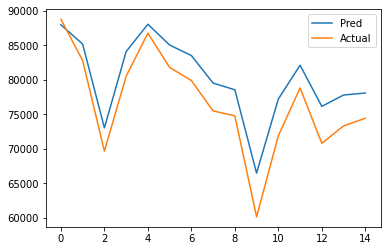

In [147]:
from sklearn.svm import SVR
# Get data function
def get_data(df):  
    data = df_.copy()
    data['Date'] = data['Date'].str.split('-').str[1]
    data['Date'] = pd.to_numeric(data['Date'])
    return [ data['Date'].tolist(), data['Daily Confirmed'].tolist() ] # Convert Series to list
dates, dc = get_data(df)
#print(dates, dc)

Svr=SVR(kernel='rbf', C=2, gamma= 0.5)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(data_train,label_train)
print(Svr.score(data_test,label_test))
Y_pred = Svr.predict(data_test)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
from math import sqrt
from sklearn import metrics
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

a = df['Daily Confirmed'].loc[240:255]
stats_df = []
for i in a:
  stats_df.append(i)
print(stats)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)

plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

Multivaraite - Daily_Recovered Prediction

(255, 3)
0.6663389220693192
RMSE value of the SVR Model is: 2072.1510401834453


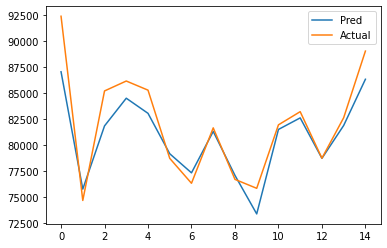

In [155]:
from sklearn.svm import SVR
df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 1].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 1].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()


Svr=SVR(kernel='rbf', C=2, gamma= 0.5)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(data_train,label_train)
print(Svr.score(data_test,label_test))
Y_pred = Svr.predict(data_test)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation


#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
#print(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))

a = df['Daily Recovered'].loc[240:255]
stats_df = []
for i in a:
  stats_df.append(i)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)

plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

Multivariate - Daily_Deceased Prediction

(255, 3)
0.46919538613331085
RMSE value of the SVR Model is: 50577.36716160698


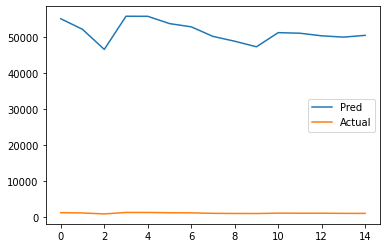

In [157]:
from sklearn.svm import SVR
df = df[['Daily Confirmed', 'Daily Recovered', 'Daily Deceased']]
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
data = sc.fit_transform(df.values)
data = pd.DataFrame(data)
print(data.shape)
#------------------------------->Data for daily confirmed prediction <------------------
data_train = data.loc[:239].to_numpy()
label_train = data.loc[:239, 2].to_numpy() #df.loc[:239,'Daily Confirmed'].to_numpy()
data_test = data.loc[240:].to_numpy()
label_test = data.loc[240:, 2].to_numpy() #df.loc[240:,'Daily Confirmed'].to_numpy()


Svr=SVR(kernel='rbf', C=1, gamma= 0.3)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(data_train,label_train)
print(Svr.score(data_test,label_test))
Y_pred = Svr.predict(data_test)

test_inp = []
for i in Y_pred:
  test_inp.append([i, 0, 0])   #padding to make dimensions equal so as to enable inverse scalar operation
#print(test_inp)

#---------------------> Inverse scalar transformation <-------------------------
import numpy as np
stats = []
num_features = 3
actual_predictions = sc.inverse_transform(np.array(test_inp).reshape(-1,num_features))
length = len(actual_predictions)
for i in range(length):
  stats.append(int(actual_predictions[i][0]))
#print(actual_predictions)
a = df['Daily Deceased'].loc[240:255]
stats_df = []
for i in a:
  stats_df.append(i)

error = sqrt(metrics.mean_squared_error(stats_df,stats)) #calculate rmse
print('RMSE value of the SVR Model is:', error)


plt.plot(stats)
plt.plot(stats_df)
plt.legend(['Pred', 'Actual'])
plt.show()

### **Polynomial Regression** Model